In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


The thing should take around 10gb of gpu memory when being trained

In [2]:
device = 'cuda'
model_checkpoint = "bert-large-uncased"

## Exploring the data

In [3]:
import pandas as pd

In [4]:
raw_train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
raw_test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [5]:
len(raw_train_df)

7613

In [6]:
raw_train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
raw_test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
duplicates_df = raw_train_df[raw_train_df.text.duplicated(keep=False)].sort_values('text')
duplicates_df.head()

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6363,9095,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1


## Clean the data

As we've seen, there are dosens of duplicated tweets. Moreover, their labes are sometimes contradictory.

In [9]:
duplicates_df[:20]

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6363,9095,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6377,9113,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6378,9114,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
2828,4064,displaced,NaN,#KCA #VoteJKT48ID 12News: UPDATE: A family of ...,1


In [10]:
duplicated_tweets = list(duplicates_df.text)

In [11]:
len(duplicated_tweets)

179

Now search for contradictions

In [12]:
contradictory_tweets = set()
for tweet in duplicated_tweets:
    if len(set(duplicates_df[duplicates_df['text'] == tweet].target)) > 1:
        contradictory_tweets.add(tweet)

contradictory_tweets = list(contradictory_tweets)
print(len(contradictory_tweets), type(contradictory_tweets))

18 <class 'list'>


We're going to label those manually

In [13]:
for i, tweet in enumerate(contradictory_tweets):
    print(i, tweet, '\n')

0 To fight bioterrorism sir. 

1 He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam 

2 like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit 

3 that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time 

4 Caution: breathing may be hazardous to your health. 

5 Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE 

6 #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect 

7 #foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption 

8 Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #isla

In [14]:
no_duplicates_train_df = raw_train_df.drop_duplicates('text')
print(len(no_duplicates_train_df))

7503


In [15]:
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[0], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[1], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[2], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[3], 'target'] = 0 
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[4], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[5], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[6], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[7], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[8], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[9], 'target'] = 1
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[10], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[11], 'target'] = 1
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[12], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[13], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[14], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[15], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[16], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[17], 'target'] = 1

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [16]:
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[12], 'target']

1197    0
Name: target, dtype: int64

## Create the Datasets

In [17]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer,AutoModel

from tqdm import tqdm
from copy import deepcopy
import random

In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [19]:
class LabeledDisasterTweetsDataset(Dataset):
    def __init__(self, 
                 df, 
                 tokenizer, 
                 max_tweet_len=180, 
                 tweet_column='text',
                 location_column='location', 
                 keyword_column='keyword', 
                 target_column='target', 
                 device='cpu',
                 text_prep_f=None):
        
        self._data = []
        
        for index, row in tqdm(df.iterrows(), total=len(df), ncols=70):
            text = row[tweet_column] if text_prep_f == None else text_prep_f(row[tweet_column], row[keyword_column], row[location_column])
            tokenized = tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors='pt')
            self._data.append(((tokenized['input_ids'][0].to(device), tokenized['attention_mask'][0].to(device)), torch.tensor(row[target_column]).to(device)))
        
        print('NOTE: you can safely delete the dataframe')
        
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, i):
        """return: ((input_ids, attention_mask), target)"""
        return self._data[i] 
    
    def train_valid_split(self, train_fraction=.9, shuffle=True):
        num_train_examples = int(len(self) * train_fraction)
        
        train_dataset = deepcopy(self)
        
        if shuffle:
            random.shuffle(train_dataset._data)
        
        valid_dataset = deepcopy(train_dataset)
        train_dataset._data = train_dataset._data[:num_train_examples]
        valid_dataset._data = valid_dataset._data[num_train_examples:]
        
        print('NOTE: you can safely delete parent dataset. The train|valid split is {}|{}.'.format(len(train_dataset), len(valid_dataset)))
        
        return train_dataset, valid_dataset
    
    
class UnlabeledDisasterTweetsDataset(Dataset):
    def __init__(self, 
                 df, 
                 tokenizer, 
                 max_tweet_len=180, 
                 tweet_column='text',
                 location_column='location', 
                 keyword_column='keyword',  
                 id_column='id', 
                 device='cpu',
                 text_prep_f=None):
        
        self._data = []
        
        for index, row in tqdm(df.iterrows(), total=len(df), ncols=70):
            
            text = row[tweet_column] if text_prep_f == None else text_prep_f(row[tweet_column], row[keyword_column], row[location_column])
            tokenized = tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors='pt')
            self._data.append((torch.tensor(row[id_column]).to(device) ,(tokenized['input_ids'][0].to(device), tokenized['attention_mask'][0].to(device))))
        
        print('NOTE: you can safely delete the dataframe')
        
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, i):
        """return: (id, (input_ids, attention_mask))"""
        return self._data[i] 

In [20]:
def prep_fn(text, keywords, location):
    return text + ' Location: ' + str(location) + '. Keywords: ' + str(keywords) +'.'

In [21]:
dataset = LabeledDisasterTweetsDataset(no_duplicates_train_df, tokenizer, device='cuda', text_prep_f=prep_fn)

100%|████████████████████████████| 7503/7503 [00:07<00:00, 978.83it/s]

NOTE: you can safely delete the dataframe


In [22]:
train_dataset, valid_dataset = dataset.train_valid_split()

NOTE: you can safely delete parent dataset. The train|valid split is 6752|751.


In [23]:
eval_dataset = UnlabeledDisasterTweetsDataset(raw_test_df, tokenizer, device='cuda', text_prep_f=prep_fn)

100%|███████████████████████████| 3263/3263 [00:02<00:00, 1617.01it/s]

NOTE: you can safely delete the dataframe


In [24]:
tokenizer.decode(train_dataset[0][0][0])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'[CLS] @ bradleybrad47 yeah but being fast and doing extremely high damage is what its all about if you want fast then im gonna have to get u the - location : unknown. keywords : damage. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [25]:
tokenizer.decode(eval_dataset[0][1][0])

'[CLS] just happened a terrible car crash location : nan. keywords : nan. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

## Defining the model

In [26]:
class BertClassifier(torch.nn.Module):
    def __init__(self, n_classes=2, head_dropout=.2, model_checkpoint=model_checkpoint):
        super().__init__()
        
        self.Base = AutoModel.from_pretrained(model_checkpoint)
        
        self.Head = torch.nn.Sequential(
            torch.nn.Dropout(head_dropout),
            torch.nn.Linear(1024, 1024),
            torch.nn.Dropout(head_dropout),
            torch.nn.Linear(1024,n_classes) # projection
        )
        
    def forward(self, input_ids, attention_mask=None, *argv):
        res = self.Base.forward(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        res = res[0]
        res = res[:,0,:] # encoding for <s> token
        res = self.Head(res)
        return res
    
    def parameters_num(self):
        return sum(p.numel() for p in self.parameters())

In [27]:
model = BertClassifier(head_dropout=.5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
model.forward(torch.tensor([1,2,33,2])[None])

tensor([[ 0.2015, -0.4046]], grad_fn=<AddmmBackward0>)

In [29]:
model.to(device)

BertClassifier(
  (Roberta): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elemen

In [30]:
model.forward(torch.tensor([[1]], device=device))

tensor([[-0.9936,  0.1396]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [31]:
print('Our Roberta has {:,d} parameters...'.format(model.parameters_num()))

Our Roberta has 336,193,538 parameters...


## Fine-tuning

In [32]:
from torch.utils.data import DataLoader

In [33]:
batch_size = 4

In [34]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [36]:
def train(model, 
          train_dataloader, 
          valid_dataloader, 
          steps, 
          optimizer,
          blind_steps=None,
          loss_fn=torch.nn.BCELoss(),
          main_metric=('f1', f1_score), 
          additional_metrics=[],
          filepath='model_sd.pt',
          load_best=True,
          scheduler=None,
          losses_dict=None):
    
    if blind_steps == None:
        blind_steps = len(train_dataloader) // 4
    
    def evaluate():  # the first score returned is the main
        model.eval()
        
        y_trues = []
        y_hats = []
        
        loss = 0
        k = 0
        
        with torch.no_grad():
            for batch in valid_dataloader:
                
                (ids, mask), y_true = batch
                hots = torch.nn.functional.one_hot(y_true, 2).to(device, torch.float)
                y_hat = torch.softmax(model.forward(input_ids=ids, attention_mask=mask),dim=-1)

                loss += float(loss_fn(y_hat, hots))
                k += 1
                
                for i in range(y_true.shape[0]):
                    y_trues.append(int(y_true[i]))
                    y_hats.append(1 if y_hat[i][0] < y_hat[i][1] else 0)
        
        scores = [(main_metric[0], main_metric[1](y_trues, y_hats))]
        
        for metric in additional_metrics:
            scores.append((metric[0], metric[1](y_trues, y_hats)))        
        
        model.train()
        return scores + [('valid_loss', loss/k)]
    
    
    def render_scores(scores, step, best=None):
        print('{:05d} steps'.format(step), end=' ')
        
        for score in scores:
            print("| {}: {:.3f}".format(*score), end=' ')
            
        if best != None:
            print('| best_score: {:.3f}'.format(best))
            
    
    # initial scores
    scores = evaluate()
    render_scores(scores, 0)
    best_score = scores[0][1]
    torch.save(model.state_dict(), filepath)
    
    # logs
    if losses_dict != None:
        losses_dict['train_loss'] = []
        losses_dict['valid_loss'] = []
        losses_dict[main_metric[0]] = []
    
    epoch_loss = 0
    k = 0
    
    train_iter = iter(train_dataloader)
    model.train()
    
    for step in tqdm(range(steps)):
        
        # retrieving a batch
        try:
            batch = next(train_iter)
        except:
            train_iter = iter(train_dataloader)
            batch = next(train_iter)

        (ids, mask), y_true = batch

        # prediction
        y_hat = torch.softmax(model.forward(input_ids=ids, attention_mask=mask),dim=-1)
        hots = torch.nn.functional.one_hot(y_true, 2).to(device, torch.float)
        loss = loss_fn(y_hat, hots)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if scheduler != None:
            scheduler.step()
            
        epoch_loss += float(loss)
        k+=1
        
        # evaluation
        if (step + 1) % blind_steps == 0:
            scores = evaluate() + [('train_loss', epoch_loss/k)]
            
            if losses_dict != None:
                losses_dict['valid_loss'].append(float(scores[-2][1]))
                losses_dict['train_loss'].append(float(scores[-1][1]))
                losses_dict[main_metric[0]].append(float(scores[0][1]))
            
            if scores[0][1] > best_score:
                best_score = scores[0][1]
                torch.save(model.state_dict(), filepath)
                
            render_scores(scores, step + 1, best=best_score)
            epoch_loss = 0
            k = 0
                
    if load_best:
        model.load_state_dict(torch.load(filepath))


In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6, weight_decay=2e-3)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=500) 

In [38]:
logs_dict = {}

In [40]:
train(
      model, 
      train_dataloader, 
      valid_dataloader, 
      7000, 
      optimizer, 
      blind_steps=125, 
      additional_metrics=[('precision', precision_score), ('recall', recall_score),('accuracy', accuracy_score)],
      losses_dict=logs_dict,
      scheduler=scheduler
     )

00000 steps | f1: 0.541 | precision: 0.908 | recall: 0.386 | accuracy: 0.711 | valid_loss: 0.586 

  2%|▏         | 125/7000 [01:13<14:04:04,  7.37s/it]

00125 steps | f1: 0.732 | precision: 0.800 | recall: 0.675 | accuracy: 0.782 | valid_loss: 0.497 | train_loss: 0.562 | best_score: 0.732


  4%|▎         | 250/7000 [02:26<13:49:15,  7.37s/it]

00250 steps | f1: 0.771 | precision: 0.715 | recall: 0.837 | accuracy: 0.780 | valid_loss: 0.482 | train_loss: 0.563 | best_score: 0.771


  5%|▌         | 375/7000 [03:40<13:29:39,  7.33s/it]

00375 steps | f1: 0.803 | precision: 0.844 | recall: 0.765 | accuracy: 0.834 | valid_loss: 0.414 | train_loss: 0.476 | best_score: 0.803


  7%|▋         | 500/7000 [04:51<11:58:58,  6.64s/it]

00500 steps | f1: 0.776 | precision: 0.897 | recall: 0.684 | accuracy: 0.826 | valid_loss: 0.410 | train_loss: 0.482 | best_score: 0.803


  9%|▉         | 625/7000 [06:02<11:44:58,  6.64s/it]

00625 steps | f1: 0.799 | precision: 0.762 | recall: 0.840 | accuracy: 0.814 | valid_loss: 0.433 | train_loss: 0.430 | best_score: 0.803


 11%|█         | 750/7000 [07:16<13:01:58,  7.51s/it]

00750 steps | f1: 0.810 | precision: 0.823 | recall: 0.798 | accuracy: 0.835 | valid_loss: 0.402 | train_loss: 0.418 | best_score: 0.810


 12%|█▎        | 875/7000 [08:29<12:29:46,  7.34s/it]

00875 steps | f1: 0.812 | precision: 0.782 | recall: 0.843 | accuracy: 0.827 | valid_loss: 0.408 | train_loss: 0.444 | best_score: 0.812


 14%|█▍        | 1000/7000 [09:42<12:13:19,  7.33s/it]

01000 steps | f1: 0.812 | precision: 0.826 | recall: 0.798 | accuracy: 0.836 | valid_loss: 0.390 | train_loss: 0.419 | best_score: 0.812


 16%|█▌        | 1125/7000 [10:56<12:15:33,  7.51s/it]

01125 steps | f1: 0.825 | precision: 0.813 | recall: 0.837 | accuracy: 0.843 | valid_loss: 0.397 | train_loss: 0.406 | best_score: 0.825


 18%|█▊        | 1250/7000 [12:07<10:35:44,  6.63s/it]

01250 steps | f1: 0.802 | precision: 0.846 | recall: 0.762 | accuracy: 0.834 | valid_loss: 0.385 | train_loss: 0.440 | best_score: 0.825


 20%|█▉        | 1375/7000 [13:18<10:21:59,  6.63s/it]

01375 steps | f1: 0.809 | precision: 0.850 | recall: 0.771 | accuracy: 0.839 | valid_loss: 0.381 | train_loss: 0.398 | best_score: 0.825


 21%|██▏       | 1500/7000 [14:29<10:08:13,  6.64s/it]

01500 steps | f1: 0.819 | precision: 0.856 | recall: 0.786 | accuracy: 0.847 | valid_loss: 0.376 | train_loss: 0.419 | best_score: 0.825


 23%|██▎       | 1625/7000 [15:40<9:54:33,  6.64s/it] 

01625 steps | f1: 0.813 | precision: 0.859 | recall: 0.771 | accuracy: 0.843 | valid_loss: 0.370 | train_loss: 0.405 | best_score: 0.825


 25%|██▌       | 1750/7000 [16:53<10:41:50,  7.34s/it]

01750 steps | f1: 0.830 | precision: 0.844 | recall: 0.816 | accuracy: 0.852 | valid_loss: 0.396 | train_loss: 0.387 | best_score: 0.830


 27%|██▋       | 1875/7000 [18:04<9:26:56,  6.64s/it] 

01875 steps | f1: 0.798 | precision: 0.886 | recall: 0.726 | accuracy: 0.838 | valid_loss: 0.391 | train_loss: 0.351 | best_score: 0.830


 29%|██▊       | 2000/7000 [19:15<9:12:48,  6.63s/it]

02000 steps | f1: 0.801 | precision: 0.875 | recall: 0.738 | accuracy: 0.838 | valid_loss: 0.375 | train_loss: 0.353 | best_score: 0.830


 30%|███       | 2125/7000 [20:26<8:58:58,  6.63s/it]

02125 steps | f1: 0.796 | precision: 0.895 | recall: 0.717 | accuracy: 0.838 | valid_loss: 0.384 | train_loss: 0.365 | best_score: 0.830


 32%|███▏      | 2250/7000 [21:37<8:45:08,  6.63s/it]

02250 steps | f1: 0.828 | precision: 0.868 | recall: 0.792 | accuracy: 0.855 | valid_loss: 0.399 | train_loss: 0.310 | best_score: 0.830


 34%|███▍      | 2375/7000 [22:48<8:31:33,  6.64s/it]

02375 steps | f1: 0.807 | precision: 0.874 | recall: 0.750 | accuracy: 0.842 | valid_loss: 0.381 | train_loss: 0.346 | best_score: 0.830


 36%|███▌      | 2500/7000 [23:59<8:17:30,  6.63s/it]

02500 steps | f1: 0.810 | precision: 0.853 | recall: 0.771 | accuracy: 0.840 | valid_loss: 0.382 | train_loss: 0.338 | best_score: 0.830


 38%|███▊      | 2625/7000 [25:10<8:03:41,  6.63s/it]

02625 steps | f1: 0.816 | precision: 0.831 | recall: 0.801 | accuracy: 0.840 | valid_loss: 0.402 | train_loss: 0.345 | best_score: 0.830


 39%|███▉      | 2750/7000 [26:21<7:50:08,  6.64s/it]

02750 steps | f1: 0.820 | precision: 0.839 | recall: 0.801 | accuracy: 0.844 | valid_loss: 0.405 | train_loss: 0.332 | best_score: 0.830


 41%|████      | 2875/7000 [27:32<7:36:36,  6.64s/it]

02875 steps | f1: 0.823 | precision: 0.842 | recall: 0.804 | accuracy: 0.847 | valid_loss: 0.396 | train_loss: 0.377 | best_score: 0.830


 43%|████▎     | 3000/7000 [28:43<7:22:08,  6.63s/it]

03000 steps | f1: 0.807 | precision: 0.876 | recall: 0.747 | accuracy: 0.842 | valid_loss: 0.374 | train_loss: 0.392 | best_score: 0.830


 45%|████▍     | 3125/7000 [29:54<7:08:27,  6.63s/it]

03125 steps | f1: 0.813 | precision: 0.849 | recall: 0.780 | accuracy: 0.842 | valid_loss: 0.375 | train_loss: 0.360 | best_score: 0.830


 46%|████▋     | 3250/7000 [31:05<6:54:39,  6.63s/it]

03250 steps | f1: 0.801 | precision: 0.881 | recall: 0.735 | accuracy: 0.839 | valid_loss: 0.373 | train_loss: 0.331 | best_score: 0.830


 48%|████▊     | 3375/7000 [32:18<7:23:26,  7.34s/it]

03375 steps | f1: 0.831 | precision: 0.866 | recall: 0.798 | accuracy: 0.856 | valid_loss: 0.381 | train_loss: 0.360 | best_score: 0.831


 50%|█████     | 3500/7000 [33:29<6:26:57,  6.63s/it]

03500 steps | f1: 0.822 | precision: 0.824 | recall: 0.819 | accuracy: 0.843 | valid_loss: 0.413 | train_loss: 0.289 | best_score: 0.831


 52%|█████▏    | 3625/7000 [34:42<6:53:37,  7.35s/it]

03625 steps | f1: 0.833 | precision: 0.857 | recall: 0.810 | accuracy: 0.856 | valid_loss: 0.398 | train_loss: 0.285 | best_score: 0.833


 54%|█████▎    | 3750/7000 [35:56<6:38:34,  7.36s/it]

03750 steps | f1: 0.839 | precision: 0.881 | recall: 0.801 | accuracy: 0.864 | valid_loss: 0.391 | train_loss: 0.271 | best_score: 0.839


 55%|█████▌    | 3875/7000 [37:07<5:45:26,  6.63s/it]

03875 steps | f1: 0.835 | precision: 0.857 | recall: 0.813 | accuracy: 0.858 | valid_loss: 0.406 | train_loss: 0.301 | best_score: 0.839


 57%|█████▋    | 4000/7000 [38:18<5:31:35,  6.63s/it]

04000 steps | f1: 0.819 | precision: 0.874 | recall: 0.771 | accuracy: 0.850 | valid_loss: 0.385 | train_loss: 0.292 | best_score: 0.839


 59%|█████▉    | 4125/7000 [39:29<5:17:52,  6.63s/it]

04125 steps | f1: 0.829 | precision: 0.866 | recall: 0.795 | accuracy: 0.855 | valid_loss: 0.385 | train_loss: 0.323 | best_score: 0.839


 61%|██████    | 4250/7000 [40:40<5:04:03,  6.63s/it]

04250 steps | f1: 0.824 | precision: 0.880 | recall: 0.774 | accuracy: 0.854 | valid_loss: 0.386 | train_loss: 0.326 | best_score: 0.839


 62%|██████▎   | 4375/7000 [41:51<4:51:03,  6.65s/it]

04375 steps | f1: 0.811 | precision: 0.875 | recall: 0.756 | accuracy: 0.844 | valid_loss: 0.393 | train_loss: 0.246 | best_score: 0.839


 64%|██████▍   | 4500/7000 [43:02<4:37:15,  6.65s/it]

04500 steps | f1: 0.831 | precision: 0.847 | recall: 0.816 | accuracy: 0.854 | valid_loss: 0.407 | train_loss: 0.295 | best_score: 0.839


 66%|██████▌   | 4625/7000 [44:13<4:22:36,  6.63s/it]

04625 steps | f1: 0.810 | precision: 0.872 | recall: 0.756 | accuracy: 0.843 | valid_loss: 0.411 | train_loss: 0.246 | best_score: 0.839


 68%|██████▊   | 4750/7000 [45:24<4:09:01,  6.64s/it]

04750 steps | f1: 0.818 | precision: 0.879 | recall: 0.765 | accuracy: 0.850 | valid_loss: 0.386 | train_loss: 0.295 | best_score: 0.839


 70%|██████▉   | 4875/7000 [46:35<3:54:58,  6.63s/it]

04875 steps | f1: 0.830 | precision: 0.879 | recall: 0.786 | accuracy: 0.858 | valid_loss: 0.386 | train_loss: 0.355 | best_score: 0.839


 71%|███████▏  | 5000/7000 [47:46<3:41:16,  6.64s/it]

05000 steps | f1: 0.829 | precision: 0.876 | recall: 0.786 | accuracy: 0.856 | valid_loss: 0.395 | train_loss: 0.261 | best_score: 0.839


 73%|███████▎  | 5125/7000 [48:57<3:27:33,  6.64s/it]

05125 steps | f1: 0.828 | precision: 0.853 | recall: 0.804 | accuracy: 0.852 | valid_loss: 0.439 | train_loss: 0.224 | best_score: 0.839


 75%|███████▌  | 5250/7000 [50:07<3:13:24,  6.63s/it]

05250 steps | f1: 0.815 | precision: 0.802 | recall: 0.828 | accuracy: 0.834 | valid_loss: 0.499 | train_loss: 0.217 | best_score: 0.839


 77%|███████▋  | 5375/7000 [51:18<2:59:34,  6.63s/it]

05375 steps | f1: 0.818 | precision: 0.811 | recall: 0.825 | accuracy: 0.838 | valid_loss: 0.493 | train_loss: 0.243 | best_score: 0.839


 79%|███████▊  | 5500/7000 [52:29<2:45:49,  6.63s/it]

05500 steps | f1: 0.814 | precision: 0.870 | recall: 0.765 | accuracy: 0.846 | valid_loss: 0.459 | train_loss: 0.196 | best_score: 0.839


 80%|████████  | 5625/7000 [53:40<2:31:57,  6.63s/it]

05625 steps | f1: 0.822 | precision: 0.844 | recall: 0.801 | accuracy: 0.847 | valid_loss: 0.422 | train_loss: 0.233 | best_score: 0.839


 82%|████████▏ | 5750/7000 [54:51<2:18:09,  6.63s/it]

05750 steps | f1: 0.818 | precision: 0.823 | recall: 0.813 | accuracy: 0.840 | valid_loss: 0.449 | train_loss: 0.227 | best_score: 0.839


 84%|████████▍ | 5875/7000 [56:02<2:04:22,  6.63s/it]

05875 steps | f1: 0.816 | precision: 0.845 | recall: 0.789 | accuracy: 0.843 | valid_loss: 0.474 | train_loss: 0.247 | best_score: 0.839


 86%|████████▌ | 6000/7000 [57:13<1:50:34,  6.63s/it]

06000 steps | f1: 0.807 | precision: 0.784 | recall: 0.831 | accuracy: 0.824 | valid_loss: 0.549 | train_loss: 0.212 | best_score: 0.839


 88%|████████▊ | 6125/7000 [58:24<1:36:41,  6.63s/it]

06125 steps | f1: 0.798 | precision: 0.905 | recall: 0.714 | accuracy: 0.840 | valid_loss: 0.458 | train_loss: 0.262 | best_score: 0.839


 89%|████████▉ | 6250/7000 [59:35<1:22:55,  6.63s/it]

06250 steps | f1: 0.811 | precision: 0.892 | recall: 0.744 | accuracy: 0.847 | valid_loss: 0.398 | train_loss: 0.287 | best_score: 0.839


 91%|█████████ | 6375/7000 [1:00:46<1:09:06,  6.63s/it]

06375 steps | f1: 0.788 | precision: 0.909 | recall: 0.696 | accuracy: 0.835 | valid_loss: 0.432 | train_loss: 0.273 | best_score: 0.839


 93%|█████████▎| 6500/7000 [1:01:57<55:20,  6.64s/it]  

06500 steps | f1: 0.813 | precision: 0.857 | recall: 0.774 | accuracy: 0.843 | valid_loss: 0.445 | train_loss: 0.275 | best_score: 0.839


 95%|█████████▍| 6625/7000 [1:03:08<41:26,  6.63s/it]

06625 steps | f1: 0.813 | precision: 0.783 | recall: 0.846 | accuracy: 0.828 | valid_loss: 0.518 | train_loss: 0.216 | best_score: 0.839


 96%|█████████▋| 6750/7000 [1:04:19<27:39,  6.64s/it]

06750 steps | f1: 0.826 | precision: 0.860 | recall: 0.795 | accuracy: 0.852 | valid_loss: 0.417 | train_loss: 0.283 | best_score: 0.839


 98%|█████████▊| 6875/7000 [1:05:30<13:50,  6.64s/it]

06875 steps | f1: 0.817 | precision: 0.834 | recall: 0.801 | accuracy: 0.842 | valid_loss: 0.555 | train_loss: 0.141 | best_score: 0.839


100%|██████████| 7000/7000 [1:06:41<00:00,  1.75it/s]

07000 steps | f1: 0.811 | precision: 0.815 | recall: 0.807 | accuracy: 0.834 | valid_loss: 0.492 | train_loss: 0.183 | best_score: 0.839


<AxesSubplot:>

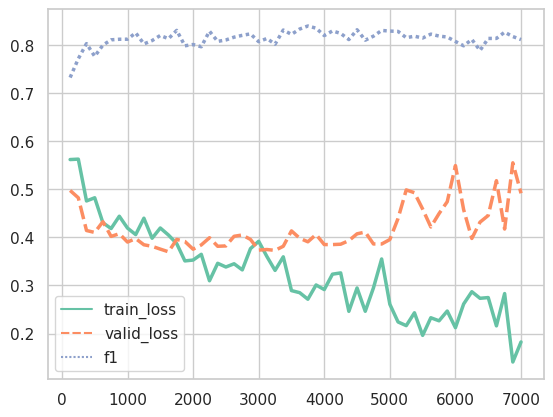

In [41]:
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")


sns.lineplot(data=pd.DataFrame(logs_dict, [(i+1) * 125 for i in range(len(logs_dict['train_loss']))]), palette="Set2", linewidth=2.5)

## Evaluate

In [42]:
model.load_state_dict(torch.load('model_sd.pt'))

<All keys matched successfully>

In [43]:
def evaluate(model, valid_dataloader, metrics=[('f1', f1_score),('precision', precision_score), ('recall', recall_score),('accuracy', accuracy_score)]):
    model.eval()

    y_trues = []
    y_hats = []

    with torch.no_grad():
        for batch in valid_dataloader:

            (ids, mask), y_true = batch
            y_hat = torch.softmax(model.forward(input_ids=ids, attention_mask=mask),dim=-1)

            for i in range(y_true.shape[0]):
                y_trues.append(int(y_true[i]))
                y_hats.append(1 if y_hat[i][0] < y_hat[i][1] else 0)

    scores = []

    for metric in metrics:
        scores.append((metric[0], metric[1](y_trues, y_hats)))        

    return scores

In [44]:
scores = evaluate(model, valid_dataloader)
print(scores)

[('f1', 0.8391167192429021), ('precision', 0.8807947019867549), ('recall', 0.8012048192771084), ('accuracy', 0.8641810918774967)]


In [45]:
def classify(tweet):
    ids = torch.tensor(tokenizer(tweet)['input_ids'])[None].to(device)
    return model.forward(input_ids=ids)

In [46]:
classify("Over 2 hundred families have become victims of my cookie-shop iniciative")

tensor([[0.0075, 0.0350]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [47]:
classify("These events are terrible. The God will make those terorists suffer. #karma #teror")

tensor([[ 0.1431, -0.1045]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Make predictions

In [48]:

predictions_df = pd.DataFrame()
for i, (ids, mask) in tqdm(eval_dataset):
    pred = model(input_ids=ids[None], attention_mask=mask[None])[0]
    y_hat = 1 if pred[0] < pred[1] else 0
    r = [int(i), y_hat]
    predictions_df = pd.concat([predictions_df, pd.DataFrame(np.array(r)[None,:], columns=['id', 'target'])])


100%|██████████| 3263/3263 [01:51<00:00, 29.19it/s]


In [49]:
predictions_df.target = predictions_df.target.astype(int)
predictions_df.id = predictions_df.id.astype(int)
predictions_df.head(20)

,id,target
0,0,1
0,2,1
0,3,1
0,9,1
0,11,1
0,12,1
0,21,0
0,22,0
0,27,0
0,29,0


In [50]:
predictions_df.to_csv('submission.csv', index=False)
predictions_df.to_csv(str(scores[0][1]) + '.csv', index=False)
print('Done!')

Done!
